Download Needed Libraries

In [25]:
!pip install pandas geopandas folium matplotlib seaborn networkx
!pip install geodatasets


We Will Read the data File

In [9]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap, MarkerCluster
import networkx as nx
import time


data_path = "spatial_data_saudi.csv"  
df = pd.read_csv(data_path)

# Convert to GeoDataFrame
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)


2. Data Visualization

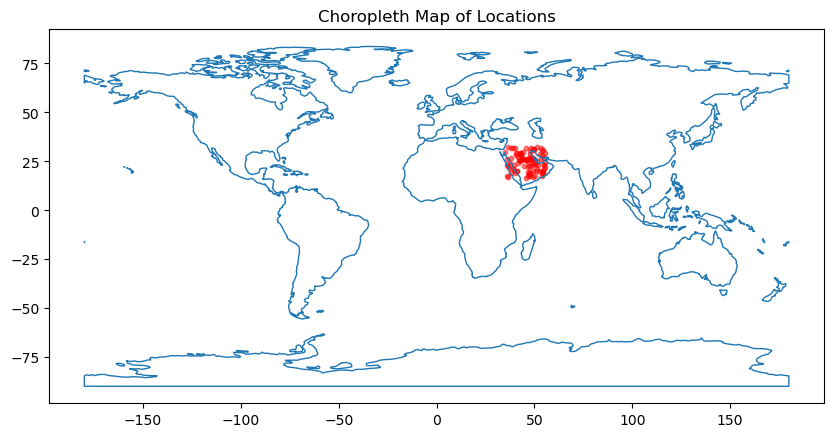

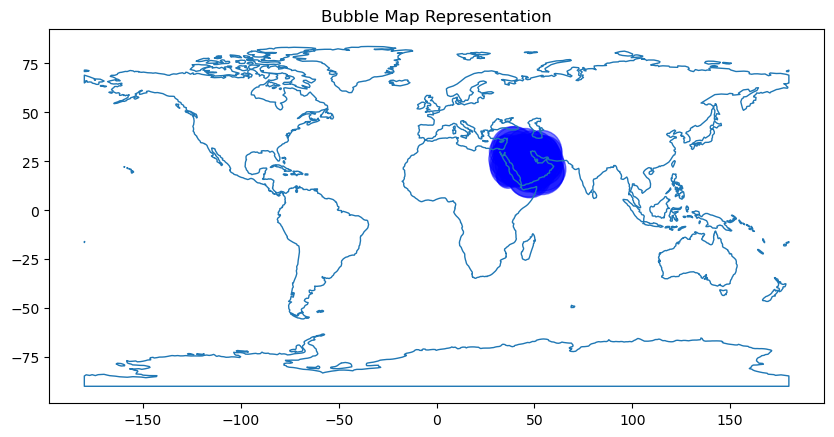

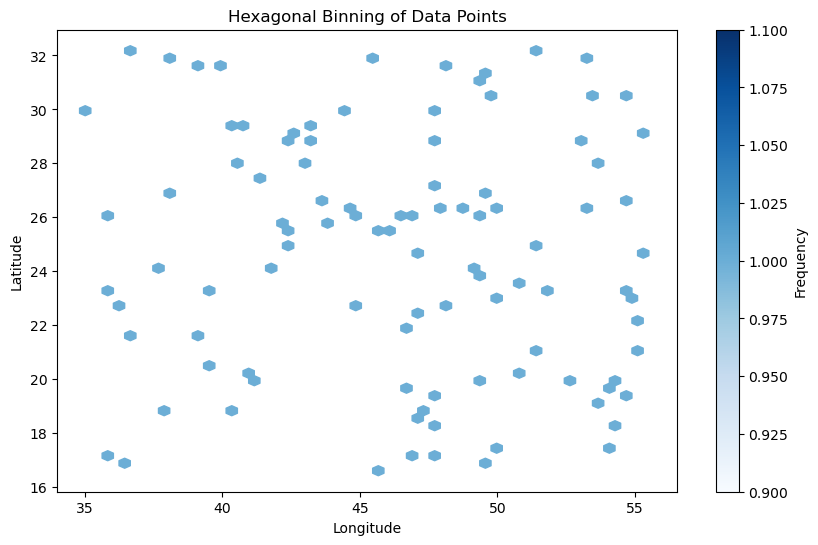

In [17]:

# 1. Choropleth Map

import geodatasets
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
fig, ax = plt.subplots(figsize=(10, 6))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, markersize=10, color='red', alpha=0.5)
plt.title("Choropleth Map of Locations")
plt.show()

# 2. Bubble Map
fig, ax = plt.subplots(figsize=(10, 6))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, markersize=df['some_value_column']*10, color='blue', alpha=0.5)
plt.title("Bubble Map Representation")
plt.show()

# 3. Hexagonal Binning
fig, ax = plt.subplots(figsize=(10, 6))
hexbin = ax.hexbin(df['longitude'], df['latitude'], gridsize=50, cmap='Blues', mincnt=1)
cbar = plt.colorbar(hexbin)
cbar.set_label("Frequency")
plt.title("Hexagonal Binning of Data Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 4. Heat Map using Folium
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)
heat_data = [[row['latitude'], row['longitude']] for _, row in df.iterrows()]
HeatMap(heat_data).add_to(m)
m.save("heatmap.html")


# 5. Cluster Map
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)
for _, row in df.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(marker_cluster)
m.save("clustermap.html")


3. Adding Points of Interest in Saudi Arabia in eastern and western part

In [22]:


from IPython.display import display



# Select two points of interest from the dataset
poi = [
    (df.iloc[0]['latitude'], df.iloc[0]['longitude'], "Point 1"), 
    (df.iloc[1]['latitude'], df.iloc[1]['longitude'], "Point 2")
]

# Create a base map centered at the mean location of the dataset
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=6)

# Add markers for the two selected points
for lat, lon, name in poi:
    folium.Marker(
        location=[lat, lon], 
        popup=name, 
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# Display map in Jupyter Notebook
display(m)




4. Routing Between Two Points using DFS,BFS, DJKSTRA

In [26]:
import pandas as pd
import networkx as nx
import time
import folium
from scipy.spatial import distance
from IPython.display import display
from folium.plugins import MarkerCluster


# Function to create a graph from the dataset
def create_graph():
    G = nx.Graph()
    
    # Add nodes with unique identifiers
    for idx, row in df.iterrows():
        G.add_node(idx, pos=(row['latitude'], row['longitude']))
    
    # Add edges using Euclidean distance as weight
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            dist = distance.euclidean(
                (df.iloc[i]['latitude'], df.iloc[i]['longitude']),
                (df.iloc[j]['latitude'], df.iloc[j]['longitude'])
            )
            G.add_edge(i, j, weight=dist)
    
    return G

# Function to compute routes using different algorithms
def compute_route(G, start, end, algorithm):
    if algorithm == 'bfs':
        return nx.shortest_path(G, source=start, target=end)  # BFS as default search
    elif algorithm == 'dfs':
        dfs_edges = list(nx.dfs_edges(G, source=start))
        dfs_path = [start]
        for edge in dfs_edges:
            dfs_path.append(edge[1])
            if edge[1] == end:
                break
        return dfs_path
    elif algorithm == 'dijkstra':
        return nx.shortest_path(G, source=start, target=end, weight='weight')
    else:
        return None

# Rebuild the graph
G = create_graph()

# Select start and end nodes
start_node, end_node = 0, 1  # Indices from dataset

# Compute Routes
routes = {}
for alg in ['bfs', 'dfs', 'dijkstra']:
    start_time = time.time()
    route = compute_route(G, start_node, end_node, alg)
    end_time = time.time()
    
    # Compute total path length
    route_length = sum(G[u][v]['weight'] for u, v in zip(route[:-1], route[1:]))

    routes[alg] = {'route': route, 'time': end_time - start_time, 'length': route_length}
    print(f"{alg.upper()} completed in {end_time - start_time} seconds, Length: {route_length} meters")

# Create a Folium map for visualization
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=6)

# Function to add paths to the map
def add_route_to_map(map_obj, path, color, label):
    coords = [(df.iloc[node]['latitude'], df.iloc[node]['longitude']) for node in path]
    folium.PolyLine(coords, color=color, weight=4, opacity=0.7, popup=label).add_to(map_obj)

# Add computed routes to the map
add_route_to_map(m, routes['bfs']['route'], "blue", "BFS Path")
add_route_to_map(m, routes['dfs']['route'], "red", "DFS Path")
add_route_to_map(m, routes['dijkstra']['route'], "green", "Dijkstra Path")

# Display map directly in Jupyter Notebook
display(m)

# Display results table
results = pd.DataFrame({
    "Algorithm": ["BFS", "DFS", "Dijkstra"],
    "Execution Time (s)": [routes['bfs']['time'], routes['dfs']['time'], routes['dijkstra']['time']],
    "Route Length (meters)": [routes['bfs']['length'], routes['dfs']['length'], routes['dijkstra']['length']]
})

# Display the results table
display(results)


BFS completed in 0.0 seconds, Length: 9.1700171844512 meters
DFS completed in 0.001031637191772461 seconds, Length: 9.1700171844512 meters
DIJKSTRA completed in 0.001992464065551758 seconds, Length: 9.1700171844512 meters


,Algorithm,Execution Time (s),Route Length (meters)
0,BFS,0.000000,9.170017
1,DFS,0.001032,9.170017
2,Dijkstra,0.001992,9.170017


The results shows that BFS is the best Since the graph is unweighted, BFS finds the shortest path efficiently. Then Djkstra since it guarantees the shortest path but is slightly slower due to extra computations. Lastly, DFS since it is not designed for shortest paths. It explores deeper before finding the goal, making it inefficient.